<div class="usecase-title"><H1>Impact of Cultural Amenities on Housing Prices</H1></div>

<div class="usecase-authors"><b>Authored by: </b>Vaibhavi Deo and Yash Daware</div>

<div class="usecase-date"><b>Date: </b> March-July 2024</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b> Level: </b>Intermediate</div>
    <div class="usecase-skill"><b> Pre-requisite Skills: </b>Python, basic machine learning, <i>Optional</i> Google Collaborate access</div>
</div>

<div class="usecase-subsection-blurb">
  <i>Dataset 1:</i> Landmarks and places of interest, including schools, theatres, health services, sports facilities, places of worship, galleries and museums.
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/landmarks-and-places-of-interest-including-schools-theatres-health-services-spor/table/" target="_blank">Dataset Link</a>
  <br>
</div>
<br>

<div class="usecase-subsection-blurb">
  <i>Dataset 2:</i>House Prices by Small Area - Sale Year
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/house-prices-by-small-area-sale-year/table/" target="_blank">Dataset Link</a>
  <br>
</div>
<br>

<div class="usecase-subsection-blurb">
  <i>Dataset 3:</i>  Small Areas for Census of Land Use and Employment (CLUE)
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/small-areas-for-census-of-land-use-and-employment-clue/table/" target="_blank">Dataset Link</a>
  <br>
</div>
<br>

<!-- <div class="usecase-subsection-blurb">
  <i>Dataset 4:</i> pedestrian-network
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-network/" target="_blank">Dataset Link</a>
  <br>
</div>
<br> -->

# <div class="usecase-section-header"><h2>Project Objective, Overview & Research</h2></div>

## Context:

The Melbourne City Council is committed to developing vibrant and liveable communities across the city.  A key factor influencing resident satisfaction is access to cultural amenities like museums, theatres, and galleries. This project investigates how the proximity of these amenities impacts housing prices in Melbourne. Understanding this relationship can inform city planning strategies to create a more equitable and culturally rich city.

## Objective:

This project will analyze the impact of cultural amenities on housing prices in Melbourne. By combining data on Melbourne landmarks (Dataset 1), house prices (Dataset 2), and potentially resident demographics, we aim to:

* Identify if there is a correlation between the proximity of cultural amenities and median house prices in different suburbs.
* Determine which types of cultural amenities (e.g., museums, theatres, performance spaces) have the strongest influence on housing prices.
* Analyze if this effect varies based on factors like housing type (houses vs. apartments) or resident demographics (age, income).

## Stakeholders:

* **Melbourne City Council Planners:** This information can guide investment decisions for cultural infrastructure projects and urban renewal initiatives. It can help create a more balanced distribution of cultural amenities across Melbourne, potentially increasing housing affordability in areas with existing amenities.
* **Real Estate Agents:** Understanding the premium placed on proximity to cultural amenities allows real estate agents to better inform their clients about the value proposition of different properties.
* **Potential Homebuyers:** This analysis can empower potential homebuyers to make informed decisions by revealing how housing prices are influenced by access to cultural amenities. They can prioritize locations that best suit their lifestyle preferences.

This project can provide valuable insights for various stakeholders interested in creating a Melbourne where cultural vibrancy and housing affordability go hand-in-hand.  


**Deliverables:**
A detailed report containing the analysis of house pricing variation, including graphs, charts, and maps.


#### USING API TO FETCH DATA FROM COM OPEN DATA WEBSITE

<H4> Data Collection

In [1]:
import requests
import pandas as pd
import os


# define function to fetch data from website using API

def fetch_data(base_url, dataset, api_key, num_records = 99, offset = 0):
    all_records = []
    max_offset = 9900  # Maximum number of requests

    while True:
        # maximum limit check
        if offset > max_offset:
            break

        # Create API request URL
        filters = f'{dataset}/records?limit={num_records}&offset={offset}'
        url = f'{base_url}{filters}&api_key={api_key}'

        # Start request
        try:
            result = requests.get(url, timeout=10)
            result.raise_for_status()
            records = result.json().get('results')
        except requests.exceptions.RequestException as e:
            raise Exception(f"API request failed: {e}")
        if records is None:
            break
        all_records.extend(records)
        if len(records) < num_records:
            break

        # next cycle offset
        offset += num_records

    # DataFrame all data
    df = pd.DataFrame(all_records)
    return df

API_KEY = os.environ.get('MELBOURNE_API_KEY', input("Please enter your API key: "))
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

Please enter your API key: 7153af1d7c894b17ff7b0341892a6440d65cde22cf0dc1b1419353f6


##### LOADING DATASETS

**Loading the House sale dataset**




In [2]:
# get data for housing prices by sale year
house_sale_data = 'house-prices-by-small-area-sale-year'

df_house_sale = fetch_data(BASE_URL, house_sale_data, API_KEY)

#df_house_sale.head()

**Loading the Landmarks and cultural amenities dataset**

In [3]:
# get data for landmarks and places of interest
landmarks_data = 'landmarks-and-places-of-interest-including-schools-theatres-health-services-spor'

df_landmarks = fetch_data(BASE_URL, landmarks_data, API_KEY)

#df_landmarks.head()

**Loading the dataset with suburb and coordinate data to append a suburb name column to the landmark dataset.**

In [4]:
# get dataset small-areas-for-census-of-land-use-and-employment-clue'

suburb_name = 'small-areas-for-census-of-land-use-and-employment-clue'

df_suburb = fetch_data(BASE_URL, suburb_name, API_KEY)

#df_suburb.head()

In [5]:
#df_landmarks.head()

In [6]:
#df_suburb.columns

In [7]:
#Data cleaning and prep

I now add a column called Suburb to the Landmarks dataset as it did not have that already and only had the name of the landmark and its coordinates. This will help me merge the housing and landmarks data togther.

In [8]:
import pandas as pd
from geopy.distance import geodesic

def extract_coordinates(geo_point):
    try:
        if isinstance(geo_point, dict):
            lat = geo_point.get('lat')
            lon = geo_point.get('lon')
            if lat is not None and lon is not None:
                return float(lat), float(lon)
            else:
                raise ValueError("Latitude or longitude is missing in Geo Point dictionary.")
        elif isinstance(geo_point, str):
            # Split the string by comma and convert to float
            lat, lon = map(float, geo_point.split(','))
            return lat, lon
        else:
            raise ValueError("Invalid Geo Point format.")
    except Exception as e:
        print("Error occurred while extracting coordinates from Geo Point:", e)
        print("Input Geo Point:", geo_point)
        return None, None


# Function to calculate distance between two points
def calculate_distance(landmark_coords, suburb_coords):
    return geodesic(landmark_coords, suburb_coords).kilometers

# List to store the suburb for each landmark
landmark_suburbs = []

# Iterate over each landmark
for landmark_coords in df_landmarks['co_ordinates']:
    # Initialize variables to store minimum distance and corresponding suburb
    min_distance = float('inf')
    closest_suburb = None

    # Convert landmark coordinates to tuple format
    landmark_coords = (landmark_coords['lat'], landmark_coords['lon'])

    # Iterate over each suburb
    for index, suburb_data in df_suburb.iterrows():
        suburb_coords = extract_coordinates(suburb_data['geo_point_2d'])
        #print("Suburb Coordinates:", suburb_coords)  # Debugging print statement

        # Calculate distance between landmark and suburb
        distance = calculate_distance(landmark_coords, suburb_coords)

        # Update closest suburb if distance is smaller
        if distance < min_distance:
            min_distance = distance
            closest_suburb = suburb_data['featurenam']

    # Append the suburb to the list
    landmark_suburbs.append(closest_suburb)

# Add the suburb information to the landmarks DataFrame
df_landmarks['suburb'] = landmark_suburbs

# Display the updated DataFrame
print(df_landmarks)


                  theme                                        sub_theme  \
0             Transport                                  Railway Station   
1             Mixed Use                            Retail/Office/Carpark   
2    Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
3      Place of Worship                                           Church   
4      Place of Worship                                           Church   
..                  ...                                              ...   
237    Education Centre         School - Primary and Secondary Education   
238              Retail                                 Department Store   
239              Retail                                 Department Store   
240     Health Services                                 Medical Services   
241           Mixed Use                            Retail/Office/Carpark   

                          feature_name  \
0    Flemington Bridge Railway Station   
1  

In [9]:
df_landmarks

,theme,sub_theme,feature_name,co_ordinates,suburb
0,Transport,Railway Station,Flemington Bridge Railway Station,"{'lon': 144.939277838304, 'lat': -37.788164588...",Parkville
1,Mixed Use,Retail/Office/Carpark,Council House 2 (CH2),"{'lon': 144.966638432727, 'lat': -37.814259143...",Melbourne (CBD)
2,Leisure/Recreation,Informal Outdoor Facility (Park/Garden/Reserve),Carlton Gardens South,"{'lon': 144.971266479841, 'lat': -37.806068457...",Melbourne (CBD)
3,Place of Worship,Church,Wesley Church,"{'lon': 144.968168215633, 'lat': -37.810157644...",Melbourne (CBD)
4,Place of Worship,Church,St Augustines Church,"{'lon': 144.954862000132, 'lat': -37.816974135...",Melbourne (CBD)
...,...,...,...,...,...
237,Education Centre,School - Primary and Secondary Education,Melbourne Girls Grammar School,"{'lon': 144.985089428348, 'lat': -37.831536451...",Melbourne (Remainder)
238,Retail,Department Store,Myer,"{'lon': 144.963855087868, 'lat': -37.813591198...",Melbourne (CBD)
239,Retail,Department Store,David Jones,"{'lon': 144.964373486798, 'lat': -37.813312726...",Melbourne (CBD)
240,Health Services,Medical Services,Mercy Private Hospital,"{'lon': 144.984435746587, 'lat': -37.811896809...",East Melbourne


  As my coordinates column is a dictionary that holds the latitude and longitude I simply split them apart into two separate groups. As this way they will both be integers that I can work with if need be.

In [10]:

# Creating a new DataFrame from the original
df_updated = df_landmarks.copy()

# Extracting longitude and latitude into separate columns
df_updated['longitude'] = df_updated['co_ordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df_updated['latitude'] = df_updated['co_ordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Optionally, drop the 'co_ordinates' column from the new DataFrame if you prefer it to be without it
df_updated.drop('co_ordinates', axis=1, inplace=True)


In [11]:
df_updated

,theme,sub_theme,feature_name,suburb,longitude,latitude
0,Transport,Railway Station,Flemington Bridge Railway Station,Parkville,144.939278,-37.788165
1,Mixed Use,Retail/Office/Carpark,Council House 2 (CH2),Melbourne (CBD),144.966638,-37.814259
2,Leisure/Recreation,Informal Outdoor Facility (Park/Garden/Reserve),Carlton Gardens South,Melbourne (CBD),144.971266,-37.806068
3,Place of Worship,Church,Wesley Church,Melbourne (CBD),144.968168,-37.810158
4,Place of Worship,Church,St Augustines Church,Melbourne (CBD),144.954862,-37.816974
...,...,...,...,...,...,...
237,Education Centre,School - Primary and Secondary Education,Melbourne Girls Grammar School,Melbourne (Remainder),144.985089,-37.831536
238,Retail,Department Store,Myer,Melbourne (CBD),144.963855,-37.813591
239,Retail,Department Store,David Jones,Melbourne (CBD),144.964373,-37.813313
240,Health Services,Medical Services,Mercy Private Hospital,East Melbourne,144.984436,-37.811897


I now plot a graph for each of the suburb to understand how many landmarks each of these suburbs have and what are their types.

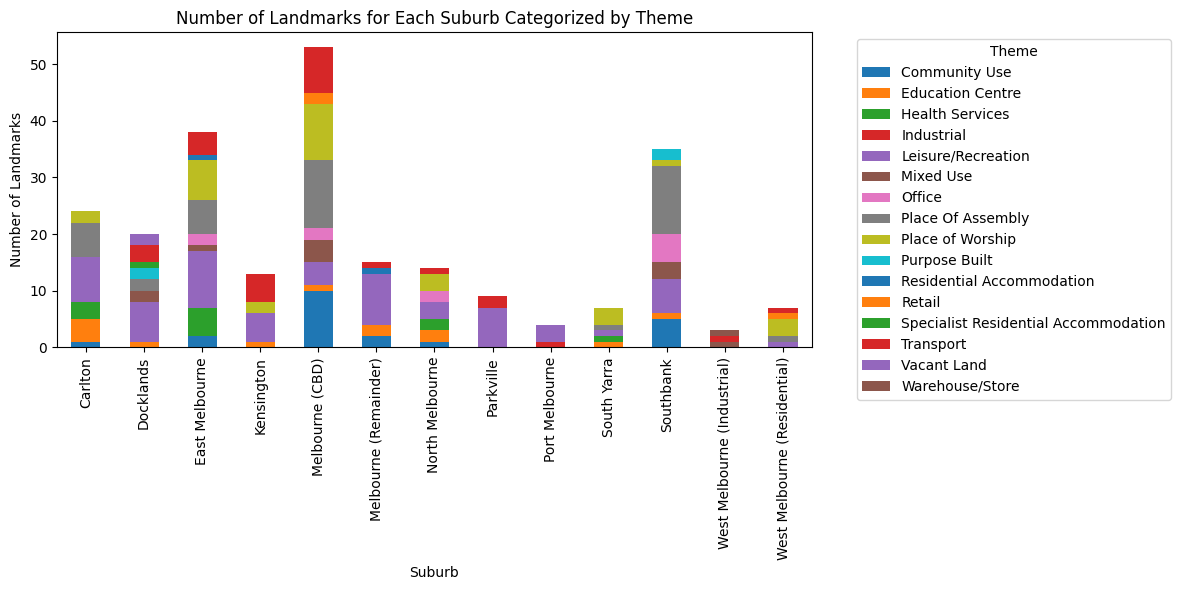

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_updated is your DataFrame
# Group by 'suburb' and 'theme', count landmarks, and unstack themes for plotting
landmarks_count = df_updated.groupby(['suburb', 'theme'])['feature_name'].count().unstack(fill_value=0)

# Plotting the data
landmarks_count.plot(kind='bar', stacked=True, figsize=(12, 6))

# Setting the chart title and labels
plt.title('Number of Landmarks for Each Suburb Categorized by Theme')
plt.xlabel('Suburb')
plt.ylabel('Number of Landmarks')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend position

# Ensure everything fits without clipping
plt.tight_layout()

# Display the plot
plt.show()


In [13]:
df_landmarks = df_updated # wanted to rename it so that I can refer to my dataset at hand with df_landmarks instead of updated.


**Distance from each of the landmark/feature to the city centre**

I wanted to undertsand how far or nearby each of the landmark was from the point of reference as City Centre. This way we created a column called distance_to_reference   to understand the proximity of the landmark and the city centtre.  

In [14]:
from geopy.distance import geodesic

# As df_landmarks already has the required columns 'longitude', 'latitude'

# Melbourne city center is used as the reference point to understand the proximity from the city centre
reference_point = (-37.8136, 144.9631)

# Function to calculate distance between the reference point and a given point in the DataFrame
def calculate_distance(lat, lon):
    return geodesic(reference_point, (lat, lon)).kilometers

# Apply the function to each row in df_landmarks
df_landmarks['distance_to_reference'] = df_landmarks.apply(lambda x: calculate_distance(x['latitude'], x['longitude']), axis=1)

# Now df_landmarks has an additional column 'distance_to_reference' with the calculated distances
print(df_landmarks[['suburb', 'feature_name', 'distance_to_reference']])

# df_landmarks



                    suburb                       feature_name  \
0                Parkville  Flemington Bridge Railway Station   
1          Melbourne (CBD)              Council House 2 (CH2)   
2          Melbourne (CBD)              Carlton Gardens South   
3          Melbourne (CBD)                      Wesley Church   
4          Melbourne (CBD)               St Augustines Church   
..                     ...                                ...   
237  Melbourne (Remainder)     Melbourne Girls Grammar School   
238        Melbourne (CBD)                               Myer   
239        Melbourne (CBD)                        David Jones   
240         East Melbourne             Mercy Private Hospital   
241        Melbourne (CBD)                  ANZ 'Gothic' Bank   

     distance_to_reference  
0                 3.517353  
1                 0.320047  
2                 1.102704  
3                 0.587500  
4                 0.816347  
..                     ...  
237             

**Count the number of features per suburb**

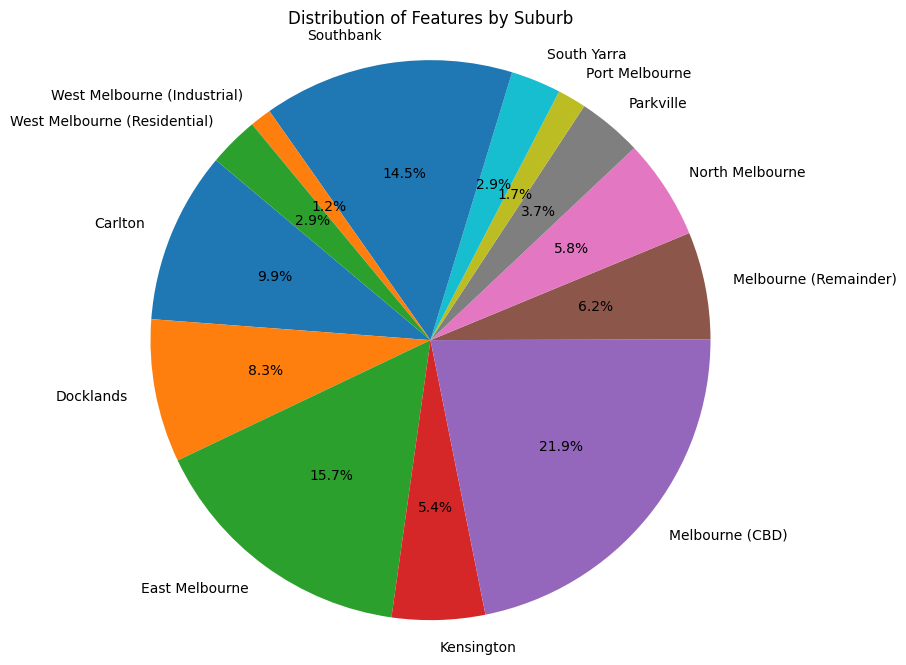

In [15]:
# Aggregate the data: Count the number of features per suburb
feature_counts = df_landmarks.groupby('suburb')['feature_name'].count()

# Plotting the pie chart
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Features by Suburb')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

**Finding our what each suburb lacks in comparison to all suburbs in Melbourne**

In [16]:
# Finding our what each suburb lacks in comparison to all suburbs in Melbourne
# Step 1: Get all unique themes
all_themes = set(df_landmarks['theme'].unique())

# Step 2: Get all unique suburbs
all_suburbs = df_landmarks['suburb'].unique()

# Step 3: Find missing themes for each suburb
missing_themes_per_suburb = {}

for suburb in all_suburbs:
    # Themes present in the current suburb
    current_suburb_themes = set(df_landmarks[df_landmarks['suburb'] == suburb]['theme'].unique())
    # Determine missing themes
    missing_themes_per_suburb[suburb] = all_themes - current_suburb_themes

# Output the results
for suburb, missing_themes in missing_themes_per_suburb.items():
    print(f"Suburb: {suburb} - Missing Themes: {missing_themes}")


Suburb: Parkville - Missing Themes: {'Vacant Land', 'Mixed Use', 'Industrial', 'Retail', 'Education Centre', 'Office', 'Purpose Built', 'Warehouse/Store', 'Place Of Assembly', 'Residential Accommodation', 'Health Services', 'Specialist Residential Accommodation', 'Place of Worship', 'Community Use'}
Suburb: Melbourne (CBD) - Missing Themes: {'Residential Accommodation', 'Vacant Land', 'Health Services', 'Specialist Residential Accommodation', 'Industrial', 'Purpose Built', 'Warehouse/Store'}
Suburb: East Melbourne - Missing Themes: {'Vacant Land', 'Industrial', 'Specialist Residential Accommodation', 'Retail', 'Education Centre', 'Purpose Built', 'Warehouse/Store'}
Suburb: Carlton - Missing Themes: {'Residential Accommodation', 'Vacant Land', 'Transport', 'Mixed Use', 'Specialist Residential Accommodation', 'Retail', 'Industrial', 'Office', 'Purpose Built', 'Warehouse/Store'}
Suburb: North Melbourne - Missing Themes: {'Place Of Assembly', 'Residential Accommodation', 'Vacant Land', 'Mi

**getting the number of features in each suburb as a separate column**


In [17]:
# getting the number of features in each suburb as a separate column

features_per_suburb = df_landmarks.groupby('suburb')['feature_name'].count().reset_index(name='number_of_features')

df_landmarks = df_landmarks.merge(features_per_suburb, on='suburb', how='left')

# Verify the DataFrame structure
print(df_landmarks.head())


                theme                                        sub_theme  \
0           Transport                                  Railway Station   
1           Mixed Use                            Retail/Office/Carpark   
2  Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
3    Place of Worship                                           Church   
4    Place of Worship                                           Church   

                        feature_name           suburb   longitude   latitude  \
0  Flemington Bridge Railway Station        Parkville  144.939278 -37.788165   
1              Council House 2 (CH2)  Melbourne (CBD)  144.966638 -37.814259   
2              Carlton Gardens South  Melbourne (CBD)  144.971266 -37.806068   
3                      Wesley Church  Melbourne (CBD)  144.968168 -37.810158   
4               St Augustines Church  Melbourne (CBD)  144.954862 -37.816974   

   distance_to_reference  number_of_features  
0               3.517353   

In [18]:
df_landmarks

,theme,sub_theme,feature_name,suburb,longitude,latitude,distance_to_reference,number_of_features
0,Transport,Railway Station,Flemington Bridge Railway Station,Parkville,144.939278,-37.788165,3.517353,9
1,Mixed Use,Retail/Office/Carpark,Council House 2 (CH2),Melbourne (CBD),144.966638,-37.814259,0.320047,53
2,Leisure/Recreation,Informal Outdoor Facility (Park/Garden/Reserve),Carlton Gardens South,Melbourne (CBD),144.971266,-37.806068,1.102704,53
3,Place of Worship,Church,Wesley Church,Melbourne (CBD),144.968168,-37.810158,0.587500,53
4,Place of Worship,Church,St Augustines Church,Melbourne (CBD),144.954862,-37.816974,0.816347,53
...,...,...,...,...,...,...,...,...
237,Education Centre,School - Primary and Secondary Education,Melbourne Girls Grammar School,Melbourne (Remainder),144.985089,-37.831536,2.776974,15
238,Retail,Department Store,Myer,Melbourne (CBD),144.963855,-37.813591,0.066496,53
239,Retail,Department Store,David Jones,Melbourne (CBD),144.964373,-37.813313,0.116581,53
240,Health Services,Medical Services,Mercy Private Hospital,East Melbourne,144.984436,-37.811897,1.888213,38


In [19]:
# Rename the column in the DataFrame
df_landmarks.rename(columns={'distance_to_reference': 'distance_city_centre'}, inplace=True)

# Verify the change by displaying the first few rows of the DataFrame
print(df_landmarks.head())


                theme                                        sub_theme  \
0           Transport                                  Railway Station   
1           Mixed Use                            Retail/Office/Carpark   
2  Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
3    Place of Worship                                           Church   
4    Place of Worship                                           Church   

                        feature_name           suburb   longitude   latitude  \
0  Flemington Bridge Railway Station        Parkville  144.939278 -37.788165   
1              Council House 2 (CH2)  Melbourne (CBD)  144.966638 -37.814259   
2              Carlton Gardens South  Melbourne (CBD)  144.971266 -37.806068   
3                      Wesley Church  Melbourne (CBD)  144.968168 -37.810158   
4               St Augustines Church  Melbourne (CBD)  144.954862 -37.816974   

   distance_city_centre  number_of_features  
0              3.517353     

**Applying one hot encoding to theme column of the dataset**

In [20]:
# Apply one-hot encoding to the 'theme' column
df_landmarks_encoded = pd.get_dummies(df_landmarks, columns=['theme'], dtype=int)

# Display the first few rows to see the transformation
print(df_landmarks_encoded.head())


                                         sub_theme  \
0                                  Railway Station   
1                            Retail/Office/Carpark   
2  Informal Outdoor Facility (Park/Garden/Reserve)   
3                                           Church   
4                                           Church   

                        feature_name           suburb   longitude   latitude  \
0  Flemington Bridge Railway Station        Parkville  144.939278 -37.788165   
1              Council House 2 (CH2)  Melbourne (CBD)  144.966638 -37.814259   
2              Carlton Gardens South  Melbourne (CBD)  144.971266 -37.806068   
3                      Wesley Church  Melbourne (CBD)  144.968168 -37.810158   
4               St Augustines Church  Melbourne (CBD)  144.954862 -37.816974   

   distance_city_centre  number_of_features  theme_Community Use  \
0              3.517353                   9                    0   
1              0.320047                  53               

In [21]:
import pandas as pd

# Assuming df_landmarks is your initial DataFrame
# Convert 'theme' into dummy variables
theme_dummies = pd.get_dummies(df_landmarks['theme'], prefix='theme')

# Ensure that dummy variables are integers (this step is usually not necessary but included for completeness)
theme_dummies = theme_dummies.astype(int)

# Concatenate these dummies with the main DataFrame
df_with_dummies = pd.concat([df_landmarks, theme_dummies], axis=1)

# Group by 'suburb' and aggregate
df_suburb_info = df_with_dummies.groupby('suburb').agg({
    'number_of_features': 'mean',  # Since this is the same for all rows per suburb, mean will effectively pick any
    **{col: 'max' for col in theme_dummies.columns}  # Using max to get 0 if not present, 1 if present
}).reset_index()

# Ensure that the number_of_features is an integer
df_suburb_info['number_of_features'] = df_suburb_info['number_of_features'].astype(int)

# Print the new DataFrame to see the result
print(df_suburb_info.head())




            suburb  number_of_features  theme_Community Use  \
0          Carlton                  24                    1   
1        Docklands                  20                    0   
2   East Melbourne                  38                    1   
3       Kensington                  13                    0   
4  Melbourne (CBD)                  53                    1   

   theme_Education Centre  theme_Health Services  theme_Industrial  \
0                       1                      1                 0   
1                       1                      0                 0   
2                       0                      1                 0   
3                       1                      0                 0   
4                       1                      0                 0   

   theme_Leisure/Recreation  theme_Mixed Use  theme_Office  \
0                         1                0             0   
1                         1                1             0   
2             

We now make a dataframe of the various amenities a perticular suburb has.

In [22]:
df_suburb_info

,suburb,number_of_features,theme_Community Use,theme_Education Centre,theme_Health Services,theme_Industrial,theme_Leisure/Recreation,theme_Mixed Use,theme_Office,theme_Place Of Assembly,theme_Place of Worship,theme_Purpose Built,theme_Residential Accommodation,theme_Retail,theme_Specialist Residential Accommodation,theme_Transport,theme_Vacant Land,theme_Warehouse/Store
0,Carlton,24,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0
1,Docklands,20,0,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0
2,East Melbourne,38,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0
3,Kensington,13,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,Melbourne (CBD),53,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,0
5,Melbourne (Remainder),15,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
6,North Melbourne,14,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0
7,Parkville,9,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
8,Port Melbourne,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
9,South Yarra,7,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0


**Now cleaning the house sales data, first renaming the column small area to suburb. Then merge with df_suburb_info**

In [23]:
df_house_sale
df_house_sale = df_house_sale.rename(columns={'small_area': 'suburb'})
print(df_house_sale.columns)

Index(['sale_year', 'suburb', 'type', 'median_price', 'transaction_count'], dtype='object')


In [24]:
merged_df = df_house_sale.merge(df_suburb_info, on='suburb', how='left')


In [25]:
merged_df

,sale_year,suburb,type,median_price,transaction_count,number_of_features,theme_Community Use,theme_Education Centre,theme_Health Services,theme_Industrial,...,theme_Office,theme_Place Of Assembly,theme_Place of Worship,theme_Purpose Built,theme_Residential Accommodation,theme_Retail,theme_Specialist Residential Accommodation,theme_Transport,theme_Vacant Land,theme_Warehouse/Store
0,2000,Kensington,Residential Apartment,232500.0,46,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2000,North Melbourne,Residential Apartment,172500.0,196,14.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2000,West Melbourne (Residential),Residential Apartment,240300.0,66,7.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2001,Carlton,Residential Apartment,273000.0,366,24.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2001,Docklands,Residential Apartment,525375.0,766,20.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2016,Kensington,House/Townhouse,818750.0,172,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
343,2016,Kensington,Residential Apartment,430000.0,128,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
344,2016,Melbourne (Remainder),Residential Apartment,582500.0,80,15.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
345,2016,West Melbourne (Residential),House/Townhouse,900000.0,26,7.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## EDA for Merged data

In [26]:
# Check for NaN values in each column
print(merged_df.isnull().sum())

# Option to fill NaN values with zero if appropriate
merged_df.fillna(0, inplace=True)


sale_year                                      0
suburb                                         0
type                                           0
median_price                                  28
transaction_count                              0
number_of_features                             7
theme_Community Use                            7
theme_Education Centre                         7
theme_Health Services                          7
theme_Industrial                               7
theme_Leisure/Recreation                       7
theme_Mixed Use                                7
theme_Office                                   7
theme_Place Of Assembly                        7
theme_Place of Worship                         7
theme_Purpose Built                            7
theme_Residential Accommodation                7
theme_Retail                                   7
theme_Specialist Residential Accommodation     7
theme_Transport                                7
theme_Vacant Land   

In [27]:

# merged_df

I now add a column **total_amenities** to which holds how many categories of amenities/landmarks are present in each suburb. As I feel this will aid in knowing if prices change based on how many category of landmarks/amenities are present in each suburb.

In [28]:
# Select columns starting with 'theme_'
theme_columns = merged_df.filter(like='theme_')

# Sum these columns row-wise to count how many '1's each row has
merged_df['total_amenities'] = theme_columns.sum(axis=1)


In [29]:
# print(merged_df[['suburb', 'total_amenities']])


I now drop the columns for the suburb NA as it does not really hold much information and we can determine what suburb it may be just by looking at numbers so we drop those enteries.

In [30]:
unique_suburbs = merged_df['suburb'].unique()
print(unique_suburbs)


['Kensington' 'North Melbourne' 'West Melbourne (Residential)' 'Carlton'
 'Docklands' 'Melbourne (Remainder)' 'South Yarra' 'Melbourne (CBD)'
 'East Melbourne' 'Southbank' 'Parkville' 'NA']


In [31]:
# Remove rows where the suburb is 'NA'
merged_df = merged_df[merged_df['suburb'] != 'NA']

# Now you can print the DataFrame to confirm that the rows with 'NA' have been dropped
# print(merged_df)


In [32]:
unique_suburbs = merged_df['suburb'].unique()
print(unique_suburbs)

['Kensington' 'North Melbourne' 'West Melbourne (Residential)' 'Carlton'
 'Docklands' 'Melbourne (Remainder)' 'South Yarra' 'Melbourne (CBD)'
 'East Melbourne' 'Southbank' 'Parkville']


Analysing Housing Price changes

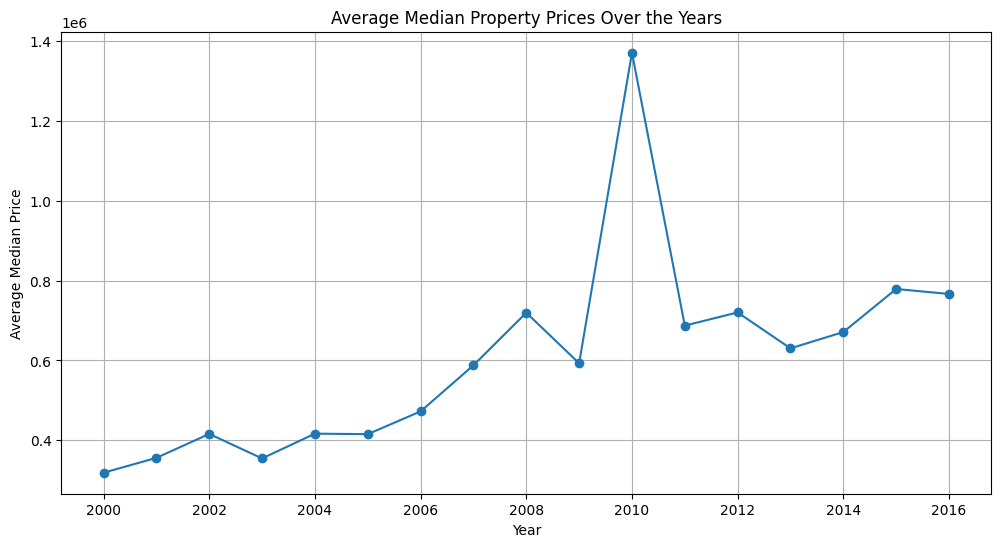

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by sale year and calculate the average median price for each year
yearly_price_trends = merged_df.groupby('sale_year')['median_price'].mean()

# Plotting the yearly trend of median prices
plt.figure(figsize=(12, 6))
yearly_price_trends.plot(kind='line', marker='o', linestyle='-')
plt.title('Average Median Property Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Median Price')
plt.grid(True)
plt.show()


## Visualizing how median prices changed year after year for the suburbs mentioned in the dataset.

From Above we see that

<ipython-input-34-1ffdf77ff454>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_data['sale_year'] = specific_data['sale_year'].astype(int)
<ipython-input-34-1ffdf77ff454>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_data['sale_year'] = specific_data['sale_year'].astype(int)
<ipython-input-34-1ffdf77ff454>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

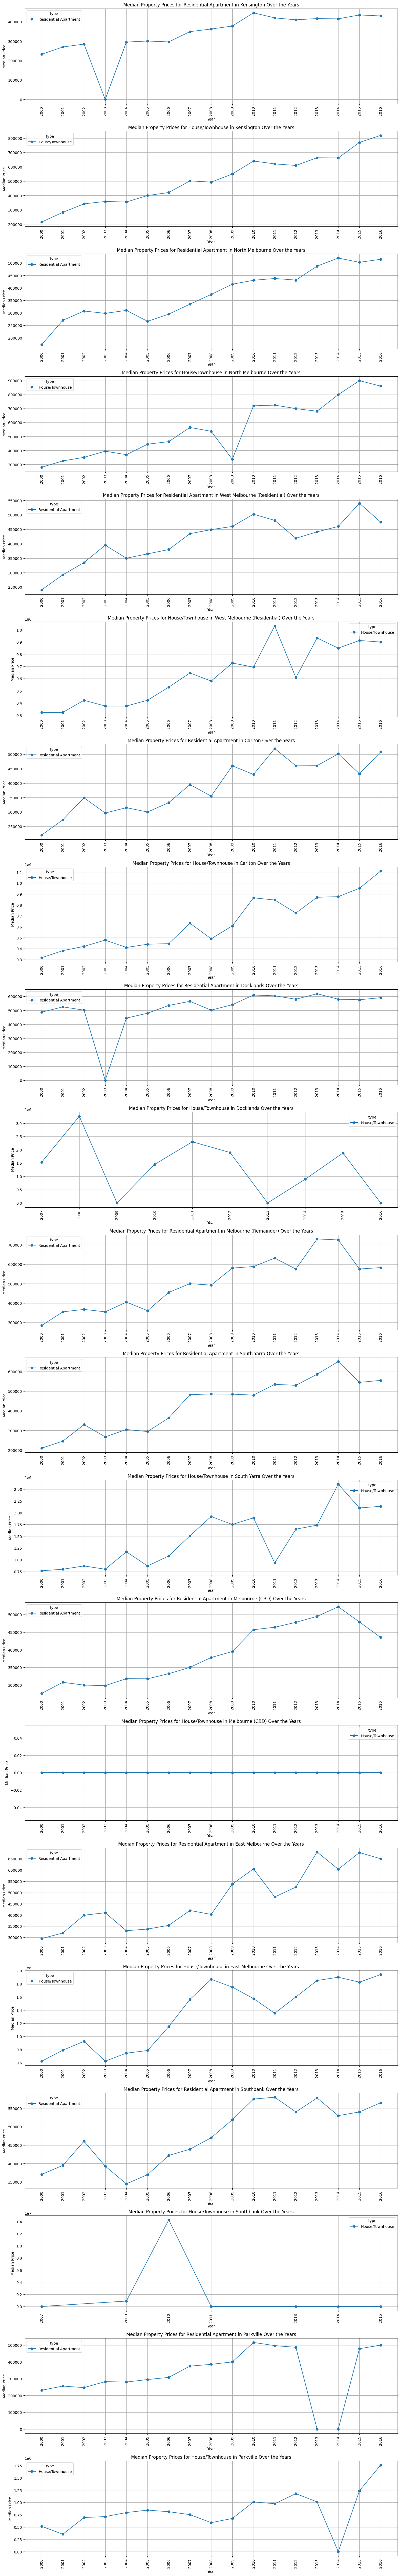

In [34]:
import matplotlib.pyplot as plt

# Get unique suburbs and types
unique_suburbs = merged_df['suburb'].unique()
unique_types = merged_df['type'].unique()

# Prepare a figure for plotting
plt.figure(figsize=(15, 100))  # Adjust the size based on the number of plots

# Loop through each suburb and each type
plot_number = 1
for suburb in unique_suburbs:
    for house_type in unique_types:
        # Filter data for specific suburb and type
        specific_data = merged_df[(merged_df['suburb'] == suburb) & (merged_df['type'] == house_type)]

        # Convert sale_year to integer if it's not already
        specific_data['sale_year'] = specific_data['sale_year'].astype(int)

        # Check if there's enough data to plot
        if not specific_data.empty:
            # Create a subplot for each suburb-type combination
            ax = plt.subplot(len(unique_suburbs) * len(unique_types), 1, plot_number)
            plot_number += 1

            # Pivot data to get median price per year
            pivot_table = specific_data.pivot_table(values='median_price', index='sale_year', columns='type', aggfunc='mean')

            # Plotting
            pivot_table.plot(kind='line', marker='o', linestyle='-', ax=ax)
            ax.set_title(f'Median Property Prices for {house_type} in {suburb} Over the Years')
            ax.set_xlabel('Year')
            ax.set_ylabel('Median Price')
            ax.grid(True)

            # Set X-axis to have ticks for each unique year present in the specific data
            years = specific_data['sale_year'].unique()
            years.sort()  # Ensure the years are sorted
            ax.set_xticks(years)  # Set ticks at every unique year
            ax.set_xticklabels(years, rotation=90)  # Rotate labels to 90 degrees for better space management

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### **Observation of median price by year for each suburb**

As we see here that for the enteries shown under NA the median prices are unavailable and thus it makes no sense to retain these values so we drop these enteries.

1. Kensington Residential apartment median price is showing 0 for year 2003, we populate it with mean of Kensington Residential apartment median price for 2002 and 2004

2. Dockland's Residential Apartments show that the median price of Residential Apartments was 0 for the year 2003, as that is not possible we replace the entery for that with mean value of Dockland's Residential Apartments for year 2002 and 2004.

3. Docklands' Median cost of house/townhouse for the year 2009 and  2013 is shown as 0 we make attempts to replace i with mean of 2013.

4. We see that median prices for House/Townhouse in Melbourne CBD is 0 throughout the year 2000 to 2016, this says that the data does not have sale of that nature.

5. Median Prices for house/townhouse in Southbank is unavailable for years prior to 2007 and even then the data is not sufficient and aly has information between 2009 to 2011 implying either ther was no house sale data available in the dataset or ther were no Houses/Townhouses sold before or after 2007 and 2011. I think its best to drop this category of housing.

6. When we see the change of median prices in Parkville we find that for the year 2013 and 2014 there is no data available in terms of Residential Apartment and thus shows median price as 2013 and 2014. We further need to delve into why that is.

7. We find that the median price for Parkville's House/Townhouse is shwon as 0 in the year 2014, we understand if that is because no entries are availabel for parkville for that year or if it holds the value 0. We must then replace it with median Parkville median price for house/Townhouse for year 2013 and 2015.


In [35]:
# merged_df.columns
merged_df

,sale_year,suburb,type,median_price,transaction_count,number_of_features,theme_Community Use,theme_Education Centre,theme_Health Services,theme_Industrial,...,theme_Place Of Assembly,theme_Place of Worship,theme_Purpose Built,theme_Residential Accommodation,theme_Retail,theme_Specialist Residential Accommodation,theme_Transport,theme_Vacant Land,theme_Warehouse/Store,total_amenities
0,2000,Kensington,Residential Apartment,232500.0,46,13.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
1,2000,North Melbourne,Residential Apartment,172500.0,196,14.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
2,2000,West Melbourne (Residential),Residential Apartment,240300.0,66,7.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0
3,2001,Carlton,Residential Apartment,273000.0,366,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,2001,Docklands,Residential Apartment,525375.0,766,20.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2016,Docklands,Residential Apartment,591000.0,371,20.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,8.0
342,2016,Kensington,House/Townhouse,818750.0,172,13.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
343,2016,Kensington,Residential Apartment,430000.0,128,13.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
344,2016,Melbourne (Remainder),Residential Apartment,582500.0,80,15.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0


I convert the `sale_year` to an integer, handle zero values in `median_price` by grouping the DataFrame by `suburb` and `type`, and use interpolation and mean filling to replace zeros. I then check for any remaining zero values and display the updated DataFrame.

In [36]:
import pandas as pd
import numpy as np

# Assuming 'merged_df' is your DataFrame
# Step 1: Convert 'sale_year' to integer if it's not already
merged_df['sale_year'] = merged_df['sale_year'].astype(int)

# Step 2: Handle zeros in 'median_price'
def handle_zero_median_prices(df):
    # Group by 'suburb' and 'type' to work within each category
    grouped = df.groupby(['suburb', 'type'])

    # Function to apply to each group
    def fill_prices(group):
        # Use linear interpolation first
        group['median_price'] = group['median_price'].replace(0, np.nan).interpolate()

        # If NaNs remain, fill with the group's mean
        if group['median_price'].isna().any():
            mean_val = group['median_price'].mean(skipna=True)
            group['median_price'] = group['median_price'].fillna(mean_val)

        return group

    # Apply the function to each group and return the combined result
    return grouped.apply(fill_prices)

# Step 3: Apply the function to the DataFrame
merged_df = handle_zero_median_prices(merged_df)

# Optional: Check if any zero values still remain and print them
remaining_zeros = merged_df[merged_df['median_price'] == 0]
print("Remaining entries with zero median prices:", len(remaining_zeros))

# Display some of the updated DataFrame to verify changes
print(merged_df.head())


Remaining entries with zero median prices: 0
                             sale_year   suburb             type  \
suburb  type                                                       
Carlton House/Townhouse 8         2002  Carlton  House/Townhouse   
                        35        2007  Carlton  House/Townhouse   
                        77        2014  Carlton  House/Townhouse   
                        98        2001  Carlton  House/Townhouse   
                        125       2005  Carlton  House/Townhouse   

                             median_price  transaction_count  \
suburb  type                                                   
Carlton House/Townhouse 8        420000.0                108   
                        35       632500.0                108   
                        77       876000.0                 68   
                        98       381000.0                113   
                        125      440000.0                 87   

                             

<ipython-input-36-ad1533adfd10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['sale_year'] = merged_df['sale_year'].astype(int)


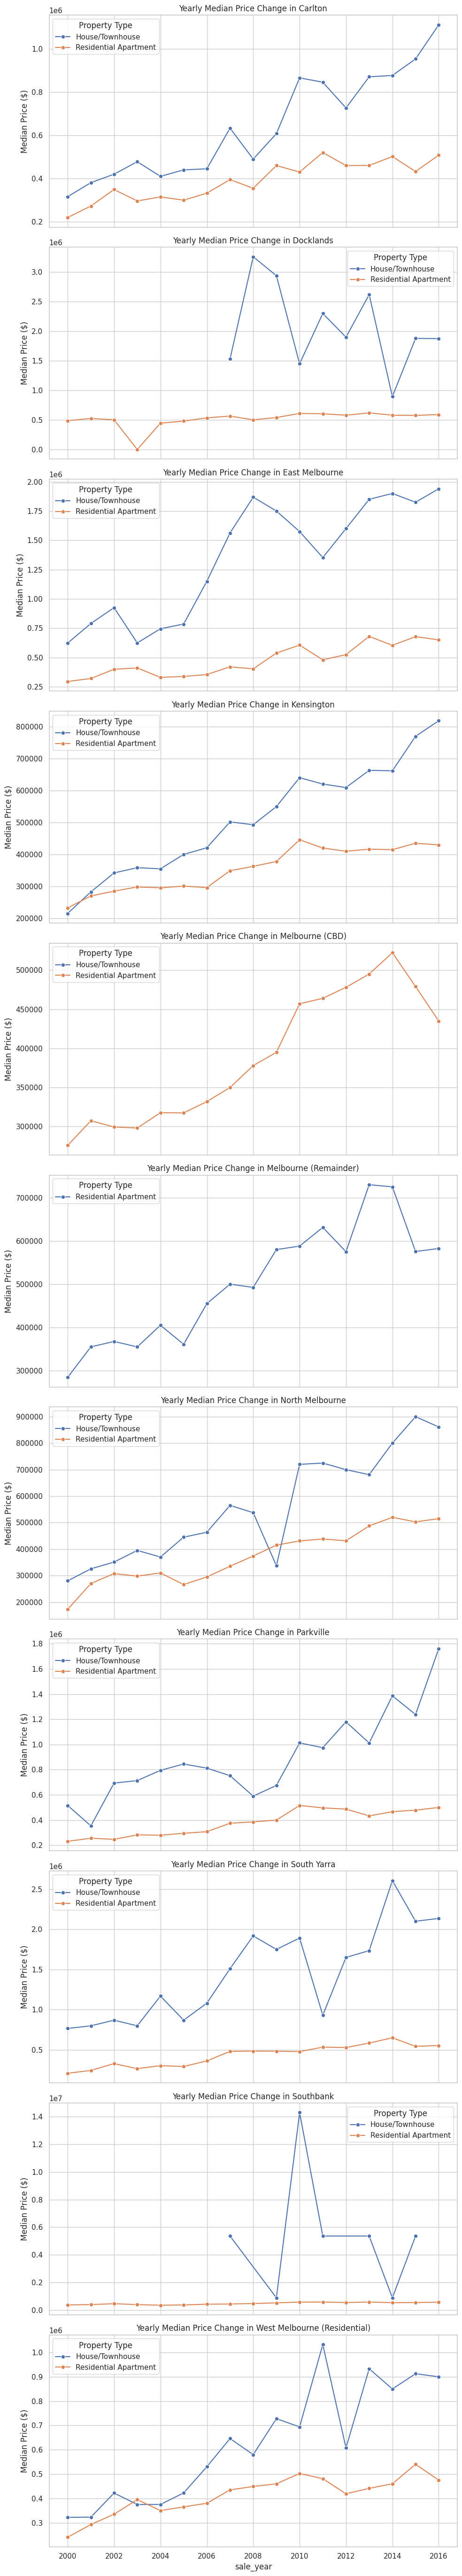

In [37]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_price_changes(df):
    # Ensure unique style for each plot
    sns.set(style="whitegrid")

    # Get unique suburbs
    suburbs = df['suburb'].unique()

    # Create a figure with subplots
    num_suburbs = len(suburbs)
    fig, axs = plt.subplots(num_suburbs, 1, figsize=(10, 5 * num_suburbs), sharex=True)

    # If only one suburb, wrap axs in a list for consistent indexing
    if num_suburbs == 1:
        axs = [axs]

    for idx, suburb in enumerate(suburbs):
        # Filter the DataFrame for the current suburb
        suburb_data = df[df['suburb'] == suburb]

        # Create a lineplot for each type within the suburb
        sns.lineplot(x='sale_year', y='median_price', hue='type', data=suburb_data, ax=axs[idx], marker='o')
        axs[idx].set_title(f"Yearly Median Price Change in {suburb}")
        axs[idx].set_ylabel("Median Price ($)")
        axs[idx].legend(title='Property Type')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_price_changes(merged_df)


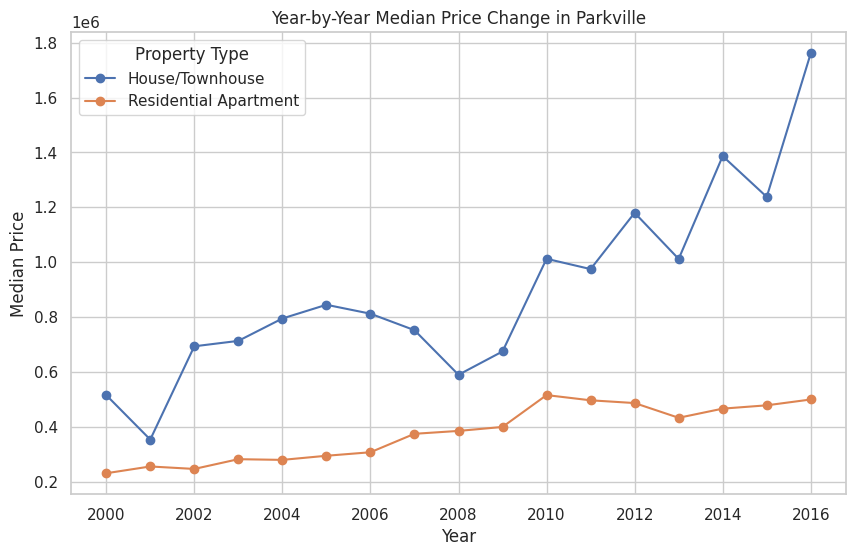

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged_df' is your DataFrame

# Reset the index to make sure that all columns are treated equally and to avoid MultiIndex complexity
merged_df.reset_index(inplace=True, drop=True)

# Filter the DataFrame to include only Parkville data
parkville_data = merged_df[merged_df['suburb'] == 'Parkville']

# Pivot the data to get years on the x-axis and median prices as values
# Different lines will represent different types of houses
pivot_table = parkville_data.pivot_table(index='sale_year', columns='type', values='median_price')

# Plotting
plt.figure(figsize=(10, 6))
for column in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[column], marker='o', label=column)

plt.title('Year-by-Year Median Price Change in Parkville')
plt.xlabel('Year')
plt.ylabel('Median Price')
plt.legend(title='Property Type')
plt.grid(True)
plt.show()


In [39]:
merged_df


,sale_year,suburb,type,median_price,transaction_count,number_of_features,theme_Community Use,theme_Education Centre,theme_Health Services,theme_Industrial,...,theme_Place Of Assembly,theme_Place of Worship,theme_Purpose Built,theme_Residential Accommodation,theme_Retail,theme_Specialist Residential Accommodation,theme_Transport,theme_Vacant Land,theme_Warehouse/Store,total_amenities
0,2002,Carlton,House/Townhouse,420000.0,108,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,2007,Carlton,House/Townhouse,632500.0,108,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,2014,Carlton,House/Townhouse,876000.0,68,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3,2001,Carlton,House/Townhouse,381000.0,113,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,2005,Carlton,House/Townhouse,440000.0,87,24.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,2016,West Melbourne (Residential),Residential Apartment,475000.0,115,7.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0
336,2004,West Melbourne (Residential),Residential Apartment,350000.0,74,7.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0
337,2008,West Melbourne (Residential),Residential Apartment,449000.0,181,7.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0
338,2013,West Melbourne (Residential),Residential Apartment,441250.0,252,7.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0


In [40]:
# Preparing for price prediction segment

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# as merged_df is already loaded into your workspace

# Removing duplicates
merged_df.drop_duplicates(inplace=True)

# Handling missing values
imputer = SimpleImputer(strategy='median')  # You can choose another strategy if it makes sense for your data
for column in ['median_price', 'number_of_features', 'total_amenities']:
    if merged_df[column].isnull().any():
        merged_df[column] = imputer.fit_transform(merged_df[[column]])

# Encoding categorical variables using OneHotEncoder with the updated parameter
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Using sparse_output instead of sparse
categorical_columns = ['suburb', 'type']  # Adjust this list based on your categorical data
encoded_columns = pd.DataFrame(encoder.fit_transform(merged_df[categorical_columns]))
encoded_columns.columns = encoder.get_feature_names_out(categorical_columns)
merged_df = merged_df.drop(categorical_columns, axis=1)
merged_df = pd.concat([merged_df, encoded_columns], axis=1)


# Feature Scaling
scaler = StandardScaler()
numerical_columns = ['transaction_count', 'number_of_features', 'total_amenities']  # Adjust this list based on your numerical data
merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])

# Now data is ready to be used for machine learning


in the code above I remove duplicates from the DataFrame and handle missing values in specific columns using a median imputer. Categorical variables are encoded with OneHotEncoder, dropping the first category to avoid multicollinearity. Finally, I scale the numerical features using StandardScaler to prepare the data for machine learning.

In [42]:
merged_df


,sale_year,median_price,transaction_count,number_of_features,theme_Community Use,theme_Education Centre,theme_Health Services,theme_Industrial,theme_Leisure/Recreation,theme_Mixed Use,...,suburb_East Melbourne,suburb_Kensington,suburb_Melbourne (CBD),suburb_Melbourne (Remainder),suburb_North Melbourne,suburb_Parkville,suburb_South Yarra,suburb_Southbank,suburb_West Melbourne (Residential),type_Residential Apartment
0,2002,420000.0,-0.360839,0.184518,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007,632500.0,-0.360839,0.184518,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,876000.0,-0.443623,0.184518,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2001,381000.0,-0.350491,0.184518,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005,440000.0,-0.404301,0.184518,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,2016,475000.0,-0.346352,-0.981071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
336,2004,350000.0,-0.431206,-0.981071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
337,2008,449000.0,-0.209759,-0.981071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
338,2013,441250.0,-0.062818,-0.981071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


**Splitting data into training and testing**

In [43]:
from sklearn.model_selection import train_test_split


In [44]:
# Defining the features and the target
X = merged_df.drop('median_price', axis=1)  # Drop the target column to create a features-only DataFrame
y = merged_df['median_price']               # The target column

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
#ML Model

In [46]:
from sklearn.ensemble import RandomForestRegressor


In [47]:
# Create a Random Forest Regressor model instance with default parameters
rf_model = RandomForestRegressor(random_state=42)


In [48]:
# Fit the model on the training data
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Import Evaluation Metrics

In [49]:
from sklearn.metrics import mean_squared_error, r2_score


# Predict the median prices on the test data



In [50]:
y_pred = rf_model.predict(X_test)

Calculate

In [51]:
# Calculate the R² score and Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 2300968602948.7524
R² Score: 0.27064092730484623


The Mean Squared Error (MSE) of 2.3 trillion and an R² score of around 0.27 suggest that the model's performance might not be satisfactory. The MSE indicates the average squared difference between predicted and actual values, with lower values indicating better performance. An R² score of 0.27 indicates that only about 27% of the variance in the target variable is explained by the model, which is relatively low.

In [52]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples

Retraining the model with optimized parameters, such as 200 estimators, a maximum depth of 10, and a minimum of 2 samples per leaf, could potentially improve performance. However, it's essential to evaluate the new Mean Squared Error (MSE) and R² score to assess the actual improvement. If the optimized model yields a lower MSE and higher R² score compared to the previous model, it indicates better predictive performance. This step is crucial for validating the effectiveness of the parameter tuning process.

In [53]:
# Re-train the model with the best parameters
optimized_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=42)
optimized_rf.fit(X_train, y_train)

# Predict on the test data
y_pred_opt = optimized_rf.predict(X_test)

# Calculate the new mean squared error and R² score
new_mse = mean_squared_error(y_test, y_pred_opt)
new_r2 = r2_score(y_test, y_pred_opt)

print("Optimized Mean Squared Error:", new_mse)
print("Optimized R² Score:", new_r2)


Optimized Mean Squared Error: 2127641089922.777
Optimized R² Score: 0.32558213511236456


The optimized Mean Squared Error (MSE) of approximately 2.13 trillion and R² score of about 0.33 suggest a slight improvement compared to the previous model. While the MSE decreased, indicating reduced error between predicted and actual values, the R² score increased slightly, implying a better fit of the model to the data. Although the improvement is modest, it demonstrates that tuning the model's parameters can enhance its predictive performance.

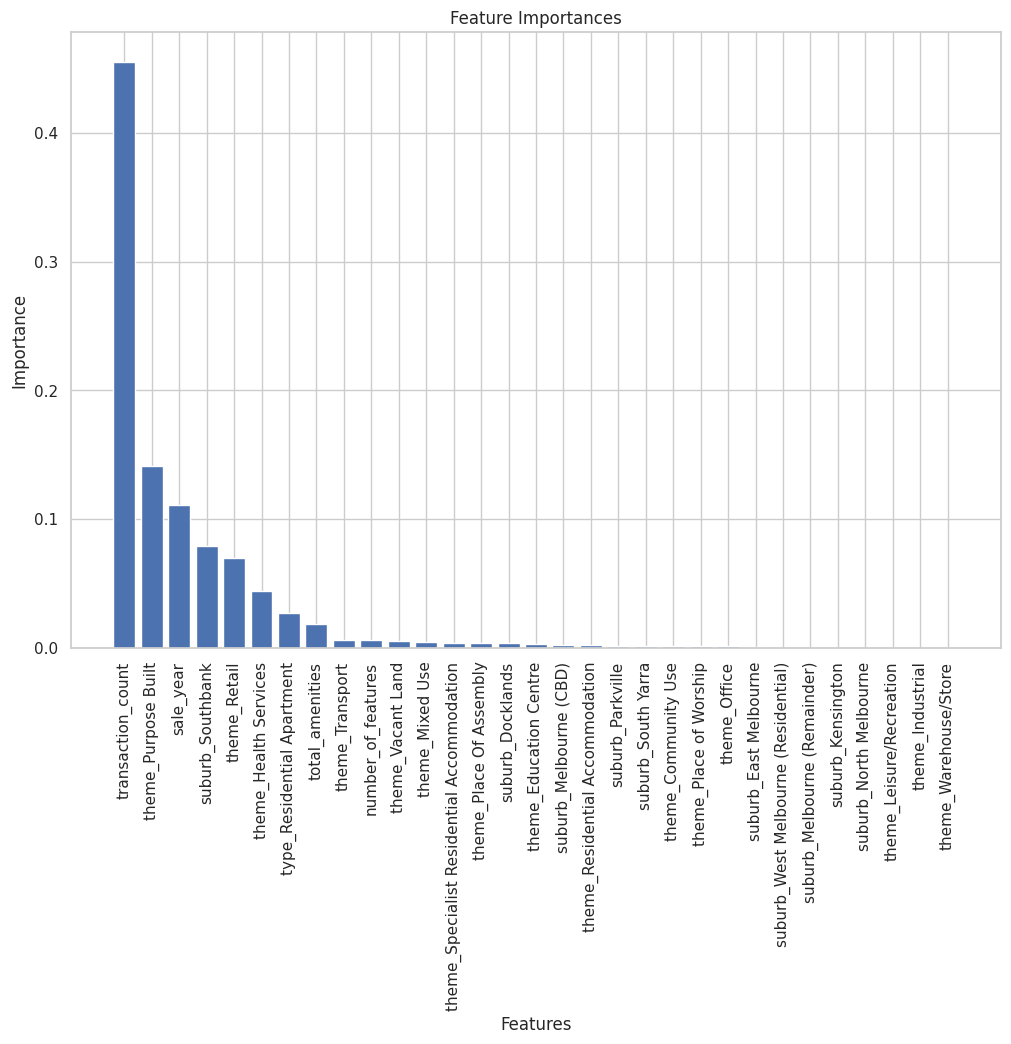

In [54]:
import matplotlib.pyplot as plt

# Get feature importances
importances = optimized_rf.feature_importances_
# Get the feature names
feature_names = X_train.columns
# Sort them by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


The above code creates a graph showing which features matter most in predicting outcomes using a RandomForestRegressor model called `optimized_rf`. First, it figures out how important each feature is in making predictions. Then, it sorts them from most to least important. Finally, it makes a bar graph where each bar represents a feature, and the height of the bar shows how important that feature is. This graph helps us understand which factors have the biggest impact on the model's predictions, which is useful for understanding our data and making decisions about which features to focus on.

In [55]:
# Get feature importances from the optimized Random Forest model
importances = optimized_rf.feature_importances_

# Convert these importances to percentages
importances_percentage = 100 * (importances / importances.sum())

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances_percentage)[::-1]

# Get the feature names, sorted by their importance
sorted_features = X_train.columns[sorted_indices]

# Combine the sorted feature names and their corresponding sorted importances
feature_importance_percentages = zip(sorted_features, importances_percentage[sorted_indices])

# Print the features and their importances
print("Feature Importances in Percentage:")
for feature, importance in feature_importance_percentages:
    print(f"{feature}: {importance:.2f}%")


Feature Importances in Percentage:
transaction_count: 45.52%
theme_Purpose Built: 14.18%
sale_year: 11.10%
suburb_Southbank: 7.90%
theme_Retail: 6.99%
theme_Health Services: 4.43%
type_Residential Apartment: 2.70%
total_amenities: 1.85%
theme_Transport: 0.64%
number_of_features: 0.63%
theme_Vacant Land: 0.56%
theme_Mixed Use: 0.51%
theme_Specialist Residential Accommodation: 0.43%
theme_Place Of Assembly: 0.39%
suburb_Docklands: 0.39%
theme_Education Centre: 0.30%
suburb_Melbourne (CBD): 0.26%
theme_Residential Accommodation: 0.21%
suburb_Parkville: 0.20%
suburb_South Yarra: 0.18%
theme_Community Use: 0.17%
theme_Place of Worship: 0.17%
theme_Office: 0.16%
suburb_East Melbourne: 0.07%
suburb_West Melbourne (Residential): 0.05%
suburb_Melbourne (Remainder): 0.01%
suburb_Kensington: 0.01%
suburb_North Melbourne: 0.01%
theme_Leisure/Recreation: 0.00%
theme_Industrial: 0.00%
theme_Warehouse/Store: 0.00%


BASED ON THIS FINDING I DO TRAINING TESTING AGAIN

In [56]:
merged_df.columns

Index(['sale_year', 'median_price', 'transaction_count', 'number_of_features',
       'theme_Community Use', 'theme_Education Centre',
       'theme_Health Services', 'theme_Industrial', 'theme_Leisure/Recreation',
       'theme_Mixed Use', 'theme_Office', 'theme_Place Of Assembly',
       'theme_Place of Worship', 'theme_Purpose Built',
       'theme_Residential Accommodation', 'theme_Retail',
       'theme_Specialist Residential Accommodation', 'theme_Transport',
       'theme_Vacant Land', 'theme_Warehouse/Store', 'total_amenities',
       'suburb_Docklands', 'suburb_East Melbourne', 'suburb_Kensington',
       'suburb_Melbourne (CBD)', 'suburb_Melbourne (Remainder)',
       'suburb_North Melbourne', 'suburb_Parkville', 'suburb_South Yarra',
       'suburb_Southbank', 'suburb_West Melbourne (Residential)',
       'type_Residential Apartment'],
      dtype='object')

In [57]:
# Assuming 'merged_df' is your original DataFrame
important_features = [
    'transaction_count', 'theme_Purpose Built', 'sale_year', 'suburb_Southbank', 'suburb_Docklands',
    'suburb_Melbourne (CBD)', 'suburb_Parkville', 'suburb_South Yarra', 'suburb_East Melbourne',
    'suburb_West Melbourne (Residential)', 'suburb_Melbourne (Remainder)', 'suburb_Kensington',
    'suburb_North Melbourne', 'total_amenities', 'theme_Retail', 'theme_Health Services',
    'type_Residential Apartment'
]

# Filter the DataFrame to keep only the important features and the target variable
reduced_df = merged_df[important_features + ['median_price']]



RESPLITTING DATA

In [58]:
from sklearn.model_selection import train_test_split

X = reduced_df.drop('median_price', axis=1)
y = reduced_df['median_price']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RETRAIN

In [59]:
from sklearn.ensemble import RandomForestRegressor

# Creating the model with optimal parameters found previously
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=42)

# Training the model
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=200,
                      random_state=42)

EVALUATE

In [60]:
from sklearn.metrics import mean_squared_error, r2_score

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error: {mse}")
print(f"Optimized R² Score: {r2}")


Optimized Mean Squared Error: 2129363588514.0762
Optimized R² Score: 0.32503613897245254
